# Eligibility traces

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
rng = np.random.default_rng()
import time
from IPython.display import clear_output

def running_average(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

## Q-learning in Gridworld

### Random interaction with the environment

The goal of this exercise is to solve the **Gridworld** problem using Q-learning. The code is adapted from  <https://github.com/rlcode/reinforcement-learning-kr>

The agent is represented by the red square: the **state** $s$ of the agent is its position in the 5x5 grid, i.e. a number between 0 and 24.

The agent can move either to the left, right, top or bottom. When the agent tries to move outside of the environment, it stays at its current position. There are four **actions** $a$ available, which are deterministic.    

Its goal is to reach the blue circle, while avoiding the green triangles. Actions leading to the blue circle receive a reward $r$ of +100, actions leading to a green triangle receive a reward of -100. The episode ends in those states. All other actions have a reward of -1.

The following code allows you to run a **random agent** in this environment for 10 episodes: at each time step, the action is selected randomly between 0 and 3 with `env.action_space.sample()`.

The environment is created with:

```python
env = Gridworld()
```

`env.render()` allows to display the Gridworld. If you pass it a Q-table (one row per state, one column per action) `env.render(Q)`, it will print the Q_value of each action at the corresponding location.

`state = env.reset()` allows to start an episode. The agent is placed at the top-left of the grid. 

`next_state, reward, done, info = env.step(action)` allows to perform an action on the environment. `action` must be a number between 0 and 3. It return the next state, the reward received during the transition, as well as a boolean `done` which is `True` when the episode is terminated (the agent moved to a blue circle or a green triangle, or 100 steps have been done), `False` otherwise. `info` contains the current undiscounted return of the episode.

**Q:** Understand and run the code. Does the agent succeed often? How complex is the task compared to Taxi?

In [2]:
class GridWorld(gym.Env):
    
    def __init__(self, rewards=[100, -100, -1], size=5):
        "Initialize the environment, can accept additional parameters such as the number of states and actions."
        
        self.size = size
        self.rewards = rewards
        
        # State space
        self.observation_space = gym.spaces.Discrete(self.size**2)
        
        # Action space
        self.action_space = gym.spaces.Discrete(4)    
        
        super().__init__()
        
        self.state = self.reset()
        self.t_max = 100
        
        self.target = (3, 2)
        self.distractor1 = (2, 2)
        self.distractor2 = (3, 3)
    
    def reset(self):
        "Resets the environment and starts from an initial state."
        
        # Sample one state randomly 
        self.state = self.rank((0, self.size-1))
        self._t = 0
        self.sum_rewards = 0.0
        
        return self.state
    
    def step(self, action):
        """
        Takes an action and returns a new state, a reward, a boolean (True for terminal states) 
        and a dictionary with additional info (optional).
        """
        self._t +=1
        self.done = False
        
        x, y = self.coordinates(self.state)
        if action == 0: # up
            y = max(min(y + 1, self.size-1), 0)
        elif action == 1: # down
            y = max(min(y - 1, self.size-1), 0)
        elif action == 2: # left
            x = max(min(x - 1, self.size-1), 0)
        elif action == 3: # right
            x = max(min(x + 1, self.size-1), 0)
        
        self.state = self.rank((x, y))
        
        if self.state == self.rank(self.target):
            self.reward = self.rewards[0]
            self.done = True
        elif self.state == self.rank(self.distractor1) or self.state == self.rank(self.distractor2):
            self.reward = self.rewards[1]
            self.done = True
        else:
            self.reward = self.rewards[2]
            
        if self._t >= self.t_max:
            self.done = True
            
        self.sum_rewards += self.reward
        self.info = {'return': self.sum_rewards}
        
        return self.state, self.reward, self.done, self.info

    def render(self, Q):
        "Displays the current state of the environment."
        
        plt.figure(figsize=(2*self.size, 2*self.size))
        
        # grid
        for i in range(1, self.size):
            plt.plot([i, i], [0, self.size], color="black")
        for i in range(1, self.size):
            plt.plot([0, self.size], [i, i], color="black")
            
        # Q-values
        for s in range(self.size*self.size):
            c = self.coordinates(s)
            plt.text(c[0] + 0.5, c[1] + 0.9, f"{Q[s, 0]:.2f}", horizontalalignment='center', verticalalignment='center')
            plt.text(c[0] + 0.5, c[1] + 0.1, f"{Q[s, 1]:.2f}", horizontalalignment='center', verticalalignment='center')
            plt.text(c[0] + 0.05, c[1] + 0.5, f"{Q[s, 2]:.2f}", horizontalalignment='left', verticalalignment='center')
            plt.text(c[0] + 0.95, c[1] + 0.5, f"{Q[s, 3]:.2f}", horizontalalignment='right', verticalalignment='center')
            
        # target
        plt.scatter([self.target[0] +0.5], [self.target[1] + 0.5], s=5000, marker="o", color="blue")
        plt.scatter([self.distractor1[0] +0.5], [self.distractor1[1] + 0.5], s=5000, marker="^", color="green")
        plt.scatter([self.distractor2[0] +0.5], [self.distractor2[1] + 0.5], s=5000, marker="^", color="green")
        
        # state
        s = self.coordinates(self.state)
        plt.scatter([s[0] + 0.5], [s[1] + 0.5], s=5000, marker="s", color="red")
        
        plt.xticks([])
        plt.yticks([])
        plt.xlim((0, self.size))
        plt.ylim((0, self.size))
        plt.title("Step " + str(self._t) + " - undiscounted return " + str(self.sum_rewards))
        
        clear_output(wait=True)
        plt.show()
    
    def coordinates(self, state):
        "Returns coordinates of a state."
        return (state % self.size, int(state/self.size))
    
    def rank(self, coord):
        "Returns rank from coordinates."
        return coord[0] + self.size*coord[1]
    

In [3]:
class RandomAgent:
    
    def __init__(self, env):
        self.env = env
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        
    def act(self, state):
        "Selects an action randomly"
        return self.env.action_space.sample()
    
    def train(self, nb_episodes, render=True):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            rewards = []

            # Sample the episode
            while not done:
                
                # Render the current state
                if render:
                    self.env.render(self.Q)
                    
                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)
                
                # Append reward
                rewards.append(reward)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                
                if done: 
                    self.env.render(self.Q)

            # Compute the discounted return of the episode.
            return_episode = np.sum(rewards)    

            # Store info
            returns.append(return_episode)
            
        return returns

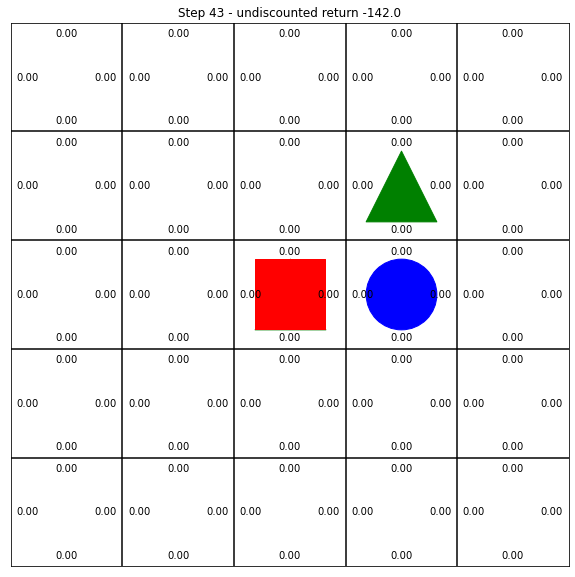

[-112, -142]


In [4]:
# Create the environment
env = GridWorld()

# Create the agent
agent = RandomAgent(env)

# Perform random episodes
returns = agent.train(2, render=True)
        
print(returns)

**Q:** Adapt your Q-learning agent from last exercise to the problem. The main difference is the call to `render()`, the rest is similar. Train it for 100 episodes with the right hyperparameters and without rendering.

**Q:** Train a Q-learning agent with rendering on. Observe in particular which Q-values are updates when the agent reaches the target. Is it efficient?

**Q:** Modify your agent so that it uses **softmax action selection**, with a temperature $\tau = 1.0$ and a suitable decay. What does it change?

If you have time, write a generic class for the Q-learning agent where you can select the action selection method flexibly.

## Eligibility traces

The main drawback of Q-learning is that it needs many episodes to converge (**sample complexity**).

One way to speed up learning is to use eligibility traces, one per state-action pair:

```python
traces = np.zeros((nb_states, nb_actions))
```

After each transition $(s_t, a_t)$, Q($\lambda$) updates a **trace** $e(s_t, a_t)$ and modifies all Q-values as:

1.  The trace of the last transition is incremented from 1:
    
$$e(s_t, a_t) = e(s_t, a_t) +1$$
    
2. Q($\lambda$)-learning is applied on **ALL** Q-values, using the TD error at time $t$:
    
$$Q(s, a) = Q(s, a) + \alpha \, (r_{t+1} + \gamma \, \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t)) \, e(s, a)$$
    
3. All traces are exponentially decreased using the trace parameter $\lambda$ (e.g. 0.7):

$$
e(s, a) = \lambda \, \gamma \, e(s, a)
$$

All traces are reset to 0 at the beginning of an episode.

**Q:** Implement eligibility traces in your Q($\lambda$)-learning agent and see if it improves convergence. Train it with rendering on and observe how all Q-values are updated.

**Q:** Vary the trace parameter $\lambda$ and discuss its influence.

**Q:** Increase the size of Gridworld to 10x10 and observe how long it takes to learn the optimal strategy.

```python
env = GridWorld(size=10)
```

Comment on the **curse of dimensionality** and the interest of tabular RL for complex tasks with large state spaces and sparse rewards (e.g. robotics).